# Algorytmy analizy skupień - NASA Close Approaches
##### Autor: Mateusz Pilch

## 1. Opis zbioru

Zbiór zawiera dane Obiektów Bliskich Ziemi (NEO ang. near-Earth objects) opublikowane przez NASA.\
W zbiorze znajduje się ponad 13 tysięcy obiektów, które zostały sklasyfikowane jako obiekty mogące zbliżyć się na relatywnie bliską odległość względem Ziemi.\
Zbiór nie posiada zmiennej celu (target).


Opis poszczególnych kolumn zbioru:
- Object - oznaczenie obiektu.
- Close-Approach (CA) Date - data i czas zbliżenia się obiektu do Ziemi.
- CA DistanceNominal (au) - najbardziej prawdopodobna odległość obiektu (od środka Ziemi do środka NEO) w jednostkach astronomicznych.
- CA DistanceMinimum (au) - minimalna odległość obiektu (od środka Ziemi do środka NEO) w jednostkach astronomicznych.
- V relative(km/s) - prędkość obiektu względem Ziemi przy bliskim podejściu.
- V infinity(km/s) - prędkość obiektu względem bezmasowej Ziemi przy bliskim podejściu.
- H(mag) - obserwowana wielkość gwiazdowa (mniejsze H oznacza większą średnicę asteroidy)
- Diameter - wartość średnicy, jeśli jest znana, lub zakres (min.–maks.) oszacowany na podstawie wielkości bezwzględnej asteroidy (H).
- Rarity - miara częstotliwości zbliżania się obiektu do Ziemi.

Źródło danych: https://cneos.jpl.nasa.gov/ca/

### Wczytanie zbioru danych

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import normalized_mutual_info_score, fowlkes_mallows_score, jaccard_score
from IPython.display import display

df = pd.read_csv('nasa_close_approaches.csv')
df


Object      Close-Approach (CA) Date  \
0           509352 (2007 AG)  1900-Jan-04 22:25 ±    00:02   
1      4660 Nereus (1982 DB)  1900-Jan-29 18:09 ±    00:35   
2                 (2009 BW2)   1900-Feb-04 06:16 ± 3_02:30   
3                  (2020 DK)   1900-Feb-10 17:56 ± 9_08:41   
4                  (2019 DB)   1900-Feb-27 07:41 ± 5_06:04   
...                      ...                           ...   
13828             (2025 BO1)   2025-Jan-19 04:50 ± < 00:01   
13829              (2025 BC)   2025-Jan-19 21:42 ± < 00:01   
13830              (2025 BA)   2025-Jan-20 01:14 ± < 00:01   
13831             (2025 BB1)  2025-Jan-20 22:19 ±    00:02   
13832            (2017 BN92)   2025-Jan-21 15:45 ± < 00:01   

       CA DistanceNominal (au)  CA DistanceMinimum (au)  V relative(km/s)  \
0                      0.00963                  0.00962              8.69   
1                      0.02080                  0.02077              5.54   
2                      0.01646                  0.01644              4.44   
3                      0.02132                  0.00738              9.90   
4                      0.02328                  0.00563              7.02   
...                        ...                      ...               ...   
13828                  0.01040                  0.01038              7.80   
13829                  0.00738                  0.00737              3.65   
13830                  0.02010                  0.02001             24.83   
13831                  0.01916                  0.01910              6.26   
13832                  0.01204                  0.01204              6.22   

       V infinity(km/s)  H(mag)        Diameter  Rarity  
0                  8.65    20.2  250 m -  550 m     2.0  
1                  5.52    18.8    0.33±0.05 km     2.0  
2                  4.41    25.1   25 m -   57 m     0.0  
3                  9.89    26.1   16 m -   36 m     0.0  
4                  7.00    26.1   16 m -   36 m     0.0  
...                 ...     ...             ...     ...  
13828              7.77    27.3  9.1 m -   20 m     0.0  
13829              3.55    26.8   11 m -   26 m     0.0  
13830             24.83    23.6   52 m -  120 m     1.0  
13831              6.24    27.4  8.8 m -   20 m     0.0  
13832              6.19    25.6   20 m -   45 m     0.0  

[13833 rows x 9 columns]

### Wyświetlenie informacji o typie danych oraz liczności

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13833 entries, 0 to 13832
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Object                    13833 non-null  object 
 1   Close-Approach (CA) Date  13833 non-null  object 
 2   CA DistanceNominal (au)   13833 non-null  float64
 3   CA DistanceMinimum (au)   13833 non-null  float64
 4   V relative(km/s)          13833 non-null  float64
 5   V infinity(km/s)          13816 non-null  float64
 6   H(mag)                    13830 non-null  float64
 7   Diameter                  13830 non-null  object 
 8   Rarity                    13830 non-null  float64
dtypes: float64(6), object(3)
memory usage: 972.8+ KB


### Wyświetlenie podstawowych statystyk dla każdej kolumny

In [ ]:
df.describe(include='all')

Object     Close-Approach (CA) Date  CA DistanceNominal (au)  \
count        13833                        13833             13833.000000   
unique       10297                        13828                      NaN   
top     (2020 CD3)  2019-Feb-26 19:24 ± < 00:01                      NaN   
freq            14                            2                      NaN   
mean           NaN                          NaN                 0.013052   
std            NaN                          NaN                 0.007401   
min            NaN                          NaN                 0.000050   
25%            NaN                          NaN                 0.006590   
50%            NaN                          NaN                 0.013210   
75%            NaN                          NaN                 0.019470   
max            NaN                          NaN                 0.025700   

        CA DistanceMinimum (au)  V relative(km/s)  V infinity(km/s)  \
count              13833.000000      13833.000000      13816.000000   
unique                      NaN               NaN               NaN   
top                         NaN               NaN               NaN   
freq                        NaN               NaN               NaN   
mean                   0.011807         10.366343         10.310654   
std                    0.007350          5.083393          5.097169   
min                    0.000000          0.610000          0.220000   
25%                    0.005270          6.860000          6.780000   
50%                    0.011430          9.450000          9.390000   
75%                    0.018040         13.010000         12.960000   
max                    0.025690         42.920000         42.910000   

              H(mag)       Diameter        Rarity  
count   13830.000000          13830  13830.000000  
unique           NaN            574           NaN  
top              NaN  11 m -   25 m           NaN  
freq             NaN            321           NaN  
mean       26.184469            NaN      0.299422  
std         2.140349            NaN      0.628642  
min        15.300000            NaN      0.000000  
25%        25.200000            NaN      0.000000  
50%        26.400000            NaN      0.000000  
75%        27.500000            NaN      0.000000  
max        33.200000            NaN      5.000000

### Wyświetlenie liczności poszczególnych wartości dla atrybutów kategorycznych

In [ ]:
df_cat = df.select_dtypes(exclude=['number'])
for attribute in df_cat.columns:
    unique_values = df[attribute].value_counts()
    print(f"Unikalne wartości atrybutu {attribute}:\n{unique_values}\n")

Unikalne wartości atrybutu Object:
Object
(2020 CD3)     14
(2019 BE5)     11
(2020 OM)      10
(2014 UR)       9
(2022 QX4)      9
               ..
(2016 RL17)     1
(2016 RN20)     1
(2016 RM40)     1
(2016 RO17)     1
(2025 BB1)      1
Name: count, Length: 10297, dtype: int64

Unikalne wartości atrybutu Close-Approach (CA) Date:
Close-Approach (CA) Date
2019-Feb-26 19:24 ± < 00:01     2
2021-Oct-06 01:57 ± < 00:01     2
2020-Feb-20 16:21 ± < 00:01     2
2023-Nov-07 01:18 ± < 00:01     2
2022-Mar-17 09:18 ± < 00:01     2
                               ..
2008-Oct-21 06:30 ± 4_08:29     1
2008-Oct-22 03:57 ±    00:13    1
2008-Oct-23 00:18 ± < 00:01     1
2008-Oct-28 07:25 ± < 00:01     1
2025-Jan-21 15:45 ± < 00:01     1
Name: count, Length: 13828, dtype: int64

Unikalne wartości atrybutu Diameter:
Diameter
11 m -   25 m     321
10 m -   23 m     303
11 m -   24 m     291
12 m -   27 m     285
16 m -   36 m     278
                 ... 
1.717±0.550 km      1
0.285±0.072 km      1
1.

### Histogramy dla atrybutów liczbowych

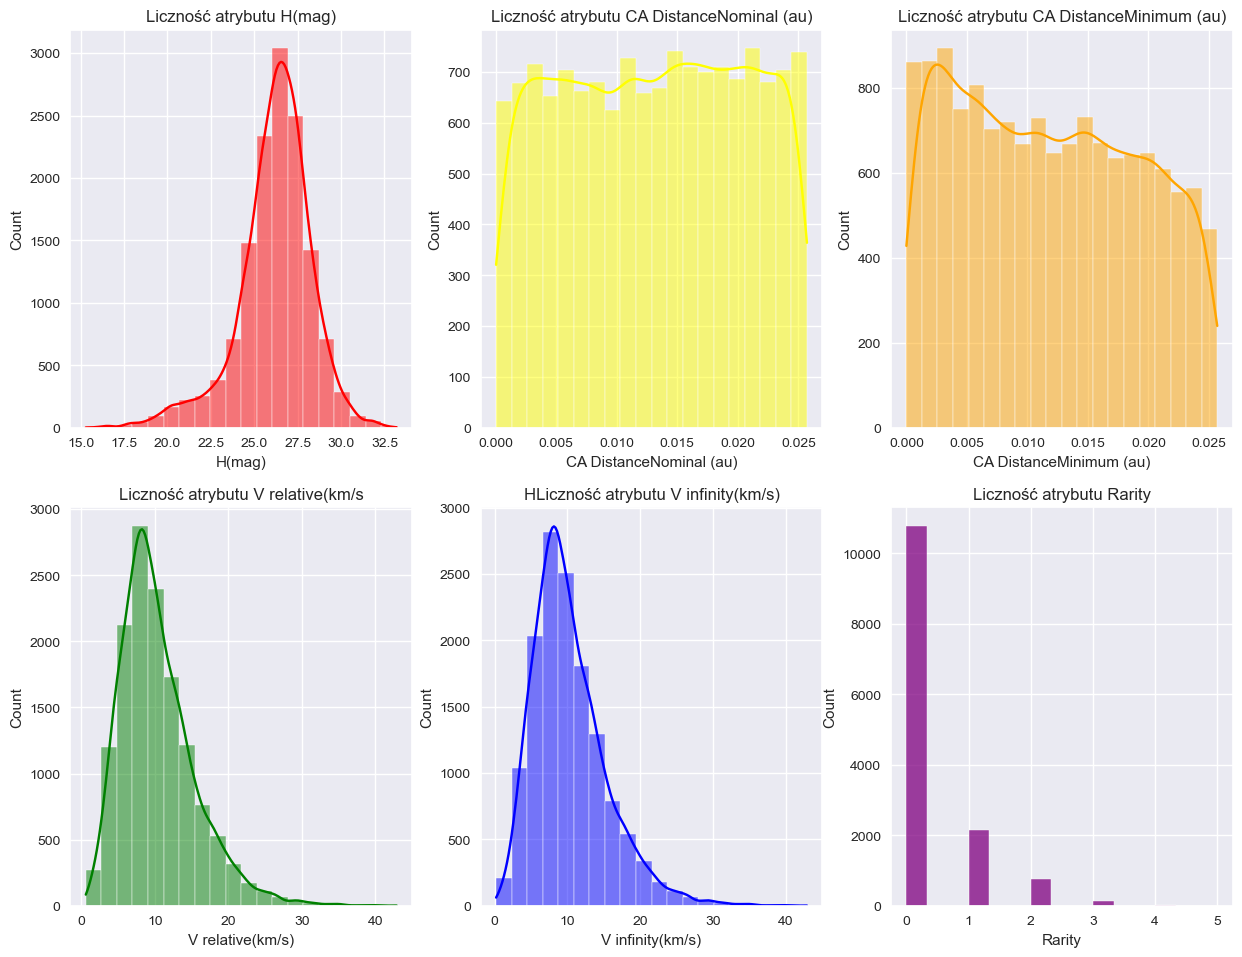

In [ ]:
plt.figure(figsize=(15,30))
plt.subplot(5,3,1)
plt.title(f'Liczność atrybutu H(mag)')
sns.histplot(df['H(mag)'], bins=20, kde=True, color='red')

plt.subplot(5,3,2)
plt.title(f'Liczność atrybutu CA DistanceNominal (au)')
sns.histplot(df['CA DistanceNominal (au)'], bins=20, kde=True, color='yellow')

plt.subplot(5,3,3)
plt.title(f'Liczność atrybutu CA DistanceMinimum (au)')
sns.histplot(df['CA DistanceMinimum (au)'], bins=20, kde=True, color='orange')

plt.subplot(5,3,4)
plt.title(f'Liczność atrybutu V relative(km/s)')
sns.histplot(df['V relative(km/s)'], bins=20, kde=True, color='green')

plt.subplot(5,3,5)
plt.title(f'Liczność atrybutu V infinity(km/s)')
sns.histplot(df['V infinity(km/s)'], bins=20, kde=True, color='blue')

plt.subplot(5,3,6)
plt.title(f'Liczność atrybutu Rarity')
sns.histplot(df['Rarity'], color='purple')

plt.show()

### Wykres wielkości obiektu względem jego odległości od Ziemi

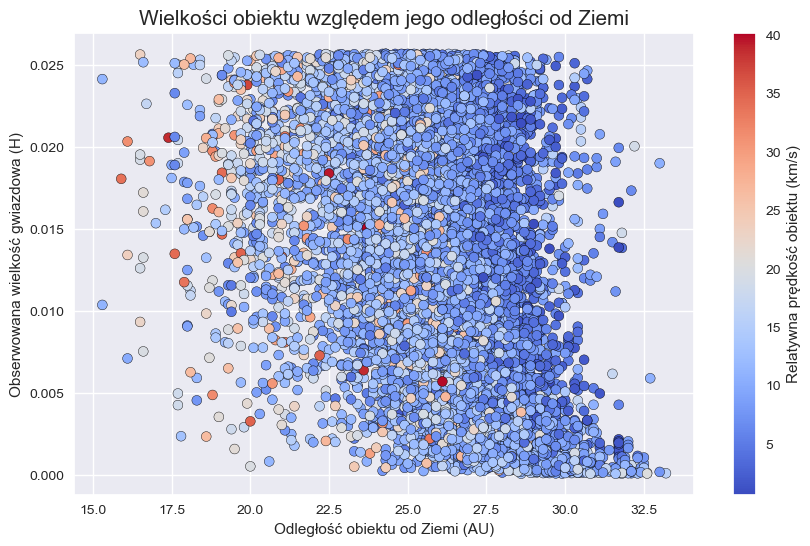

In [ ]:
plt.figure(figsize=(10, 6))

sc = plt.scatter(x=df['H(mag)'], y=df['CA DistanceNominal (au)'], c=df['V relative(km/s)'],s=50, cmap='coolwarm', edgecolor='black')

plt.title('Wielkości obiektu względem jego odległości od Ziemi', fontsize=15)
plt.xlabel('Odległość obiektu od Ziemi (AU)')
plt.ylabel('Obserwowana wielkość gwiazdowa (H)')

cbar = plt.colorbar(sc)
cbar.set_label('Relatywna prędkość obiektu (km/s)')

plt.grid(True)
plt.show()

Z wykresu możemy odczytać następujące informacje:
- Zdecydowana większość obiektów znajduje się w odległości od 22,5 do 28,5 au
- Obiekty znajdujące się bliżej Ziemi posiadają większą relatywną prędkość (oznaczone są cieplejszym kolorem na wykresie)
- Większe obiekty (o mniejszym współczynniku H) znajdują się dalej od Ziemi

### Korelacja danych
Korelacja danych to miara zależności między dwiema zmiennymi w zbiorze danych. Określa, jak jedna zmienna zmienia się w stosunku do drugiej. \
Korelacja pozwala określić w jakim stopniu dwie zmienne są ze sobą powiązane, co może pomóc w modelowaniu, analizie i wyborze cech.

Rodzaje korelacji:

- Korelacja dodatnia - Wartości zmiennych rosną lub maleją razem. Jeśli jedna zmienna wzrasta, druga również rośnie, lub jeśli jedna maleje, druga maleje. Korelacja dodatnia występuje, gdy współczynnik korelacji (r) jest większy niż 0.
- Korelacja ujemna - jedna zmienna rośnie, podczas gdy druga maleje. Korelacja ujemna występuje, gdy współczynnik korelacji (r) jest mniejszy niż 0.
- Brak korelacji - zmienne nie mają wyraźnego powiązania. Wartości jednej zmiennej mogą zmieniać się niezależnie od drugiej.
Korelacja wynosi 0, co oznacza, że nie istnieje liniowa zależność między tymi zmiennymi.

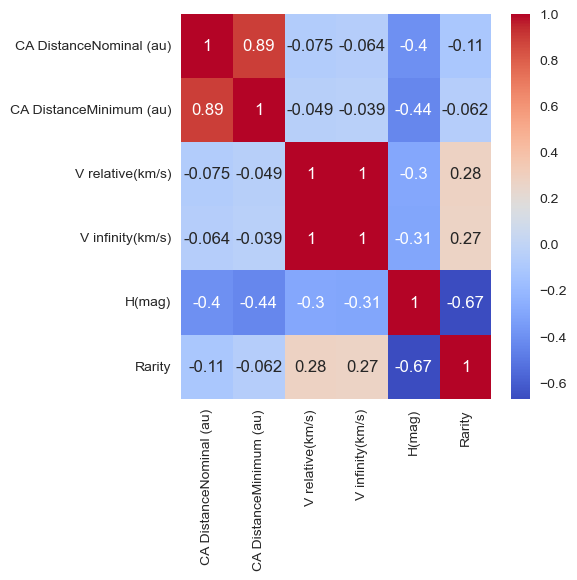

In [ ]:
df_num = df.select_dtypes(include='number')

corr = df_num.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Z macierzy korelacji można odczytać następujące zależności:
- Największa dodatnia korelacja występuje dla par CA DistanceMinimum (au) i CA DistanceNominal (au) oraz V relative(km/s) i V infinity(km/s).
- Atrybut H(mag) wykazuje średnią ujemną korelację ze wszystkimi atrybutami liczbowymi.
- Atrybut Rarity jest dodatnio skorelowany z atrybutem V relative(km/s) oraz V infinity(km/s).
- Niemal zupełny brak korelacji występuje pomiędzy atrybutami CA DistanceMinimum (au) i CA DistanceNominal (au), a V relative(km/s) i V infinity(km/s).

## 2. Preprocessing danych
Aby skutecznie przeprowadzić proces klasteryzacji, konieczne jest odpowiednie przygotowanie zbioru danych,
ponieważ algorytmy skupień są bardzo wrażliwe na jakość i strukturę danych.\
W tym celu należy wykonać szereg operacji mających na celu oczyszczenie, standaryzację i optymalizację danych pod kątem algorytmów grupowania.
Proces ten obejmuje kilka kluczowych etapów:
- Wybór danych do grupowania
- Usuwanie braków w danych
- Normalizację
- Standaryzację
- Usuwanie wartości odstających

### Wybór danych do grupowania
Ze zbioru danych wybane zostałnie kilka atrybutów, na których wykonywane będą algorytmy grupujące. \
Do przeprowadzonej analizy wykorzystane zostaną następujące atrybuty: CA DistanceNominal (au), V relative(km/s), H(mag) i Rarity. \
Wybór tych atrybutów pozwoli zweryfikować jak algorytmy poradzą sobię z utworzeniem grup dla asteroid i kosmicznych obiektów.

In [ ]:
df = df.drop(['Object','Close-Approach (CA) Date','CA DistanceMinimum (au)','V infinity(km/s)','Diameter'], axis=1)
original_df = df.copy()
df

CA DistanceNominal (au)  V relative(km/s)  H(mag)  Rarity
0                      0.00963              8.69    20.2     2.0
1                      0.02080              5.54    18.8     2.0
2                      0.01646              4.44    25.1     0.0
3                      0.02132              9.90    26.1     0.0
4                      0.02328              7.02    26.1     0.0
...                        ...               ...     ...     ...
13828                  0.01040              7.80    27.3     0.0
13829                  0.00738              3.65    26.8     0.0
13830                  0.02010             24.83    23.6     1.0
13831                  0.01916              6.26    27.4     0.0
13832                  0.01204              6.22    25.6     0.0

[13833 rows x 4 columns]

Pozostałe atrybuty zostały usunięte ze zbioru i nie będą wykorzystywane w dalszych etapach preprocessingu oraz grupowaniu.

### Usuwanie braków w danych
Przed przystąpieniem do dalszych etapów preprocessingu należy sprawdzić, czy atrybuty nie zawierają brakujących danych. \
Usuwanie brakujących wartości jest konieczne, ponieważ mogą one powodować błędy w działaniu algorytmów, zniekształcać wyniki obliczeń statystycznych i utrudniać interpretację danych.

In [ ]:
# Zliczenie ilości pustych wartości dla każdej kolumny
df_missing_count = df.isnull().sum()
df_missing_count

CA DistanceNominal (au)    0
V relative(km/s)           0
H(mag)                     3
Rarity                     3
dtype: int64

Zbiór danych zawiera niewiele brakujących wartości w porównaniu do ilości obiektów znajdujących się w zbiorze. Aby umożliwić pracę algorytmów grupowania oraz zapewnić jak najlepsze wyniki, \
wszystkie brakujące dane zostaną uzupełnione przez wartości najczęściej występujące w każdej z kolumn zbioru (moda).

In [ ]:
# Wypełnianie brakujących wartości modą
for col in list(df.columns):
    empty_values = df[col].isnull().sum()
    if empty_values > 0:
        df[col] = df[col].fillna(df[col].mode().iloc[0])

df.isnull().sum()

CA DistanceNominal (au)    0
V relative(km/s)           0
H(mag)                     0
Rarity                     0
dtype: int64

Po zastosowaniu algorytmu wypełniającego brakujące dane, wszystkie atrybuty nie zawierają już pustych wartości.

### Normalizacja
Normalizacja danych to proces przekształcania wartości w taki sposób, aby ich zakres mieścił się w określonych granicach. \
W przypadku przeprowadzanej normalizacji zakresem wartości będzie przedział [0,1]. Etap ten pozwala na eliminację wpływu różnic w skalach zmiennych na wyniki analizy. \
Bez normalizacji zmienne o większej skali mogą zdominować te o mniejszej skali, co może wpłynąć na działanie algorytmów opartych na odległości np. K-means.

In [ ]:
#Normalizacja z wykorzystaniem MixMaxScalera
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df)

df = pd.DataFrame(x_scaled)
df

0         1         2    3
0      0.373489  0.190971  0.273743  0.4
1      0.808967  0.116521  0.195531  0.4
2      0.639766  0.090522  0.547486  0.0
3      0.829240  0.219570  0.603352  0.0
4      0.905653  0.151501  0.603352  0.0
...         ...       ...       ...  ...
13828  0.403509  0.169936  0.670391  0.0
13829  0.285770  0.071851  0.642458  0.0
13830  0.781676  0.572442  0.463687  0.2
13831  0.745029  0.133538  0.675978  0.0
13832  0.467446  0.132593  0.575419  0.0

[13833 rows x 4 columns]

### Standaryzacja

Standaryzacja danych to proces przekształcania zmiennych tak, aby miały średnią równą 0 i odchylenie standardowe równe 1.
Celem standaryzacji jest usunięcie różnic w skali zmiennych, \
co jest szczególnie ważne w algorytmach, które są wrażliwe na zmienną skale, czyli tak jak w przypadku normalizacji - algorytmów opartych na odległosci. \
Standaryzacja pozwala na porównanie zmiennych w równych warunkach, niezależnie od ich pierwotnych jednostek miary.

In [ ]:
# Standaryzacja z wykorzystaniem StandardScalera
scaler = StandardScaler()
df = scaler.fit_transform(df)

df = pd.DataFrame(df)
df

0         1         2         3
0     -0.462411 -0.329780 -2.796460  2.705589
1      1.046887 -0.949468 -3.450651  2.705589
2      0.460464 -1.165866 -0.506792 -0.476253
3      1.117150 -0.091742 -0.039513 -0.476253
4      1.381986 -0.658313 -0.039513 -0.476253
...         ...       ...       ...       ...
13828 -0.358368 -0.504867  0.521223 -0.476253
13829 -0.766432 -1.321280  0.287583 -0.476253
13830  0.952303  2.845379 -1.207711  1.114668
13831  0.825289 -0.807825  0.567951 -0.476253
13832 -0.136770 -0.815694 -0.273152 -0.476253

[13833 rows x 4 columns]

### Usuwanie wartości odstających
Wartości odstające to obserwacje, które znacząco różnią się od innych w zbiorze danych i wpływać na działanie alogrytmów grupujących przez swoje odstające od reszty wartości. \
Do wykrycia obserwacji odstających wykorzystane zostaną dwie metody:

- Isolation Forest - algorytm wykrywający wartości odstające oparty na drzewach decyzyjnych. Działa w oparciu o zasadę izolacji wartości odstających, które są oddzielane szybciej niż wartości typowe.
- Z-Score - statystyczna technika identyfikacji wartości odstających, która opiera się na odległości obserwacji od średniej w jednostkach odchylenia standardowego.

#### A. Metoda Isolation Forest

In [ ]:
df_forest = df.copy()

# Algorytm Isolation Forest
clf = IsolationForest(n_estimators=100, max_samples='auto', max_features=1.0, random_state=42)
y_pred = clf.fit_predict(df_forest)
df_forest['outlier'] = y_pred

# Zliczenie wartości odstających
forest_outliers = (df_forest['outlier'] == -1).sum()
print(f'Ilość wartości odstających: {forest_outliers}')

Ilość wartości odstających: 3000


#### B. Metoda Z-Score

In [ ]:
df_zscore = df.copy()
threshold = 3

# Algorytm Z score
outliers = (df_zscore.abs() > threshold)
df_zscore['outlier'] = df_zscore.abs().max(axis=1).apply(lambda x: -1 if x > threshold else 1)

# Zliczenie wartości odstających
zscore_outliers = (df_zscore['outlier'] == -1).sum()
print(f'Ilość wartości odstających: {zscore_outliers}')

Ilość wartości odstających: 394


#### C. Usuwanie obserwacji

Po wykryciu obserwacji odstających dwoma różnymi metodami, ze zbioru danych usuwamy te obiekty, które zostały oznaczone przez obie metody jako wartości odstające.

In [ ]:
condition = (df_forest['outlier'] == -1) & (df_zscore['outlier'] == -1)

df_cleaned = df[~condition]
df = df_cleaned
original_df = original_df[~condition]

df

0         1         2         3
0     -0.462411 -0.329780 -2.796460  2.705589
2      0.460464 -1.165866 -0.506792 -0.476253
3      1.117150 -0.091742 -0.039513 -0.476253
4      1.381986 -0.658313 -0.039513 -0.476253
5      0.807724  0.427615 -1.067527  1.114668
...         ...       ...       ...       ...
13828 -0.358368 -0.504867  0.521223 -0.476253
13829 -0.766432 -1.321280  0.287583 -0.476253
13830  0.952303  2.845379 -1.207711  1.114668
13831  0.825289 -0.807825  0.567951 -0.476253
13832 -0.136770 -0.815694 -0.273152 -0.476253

[13439 rows x 4 columns]

Usuwanie wartości odstających kończy etap preprocessingu danych. Tak przygotowane dane zostaną wykorzystane w dalszej analizie skupień.

### Korelacja danych po preprocessingu

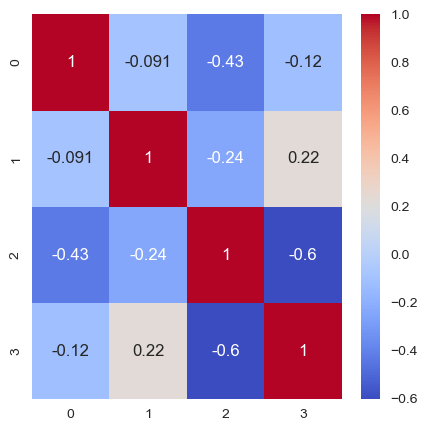

In [ ]:
df = pd.DataFrame(df)
corr = df.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Z macierzy po preporcessingu możemy odczytać następujące informacje:
- Atrybuty w niewielkim stopniu zmieniły swoje wartości korelacji
- Pary atrybutów (0,1), (0,3) i (1,2) posiadają słabą korelację ujemną.
- Jedyną dodatnią korelacją wykazuje para atrybutów (1,3).
- Średnia ujemna korelacja występuje między atrybutami (0,2) i (2,3).


## 3. Algorytmy skupień
Algorytmy skupień to techniki uczenia nienadzorowanego, które mają na celu grupowanie danych w taki sposób, aby obiekty w ramach jednego klastra były do siebie jak najbardziej podobne, \
a obiekty należące do różnych klastrów różniły się między sobą. Skupienia tworzone przez te algorytmy są definiowane na podstawie określonych miar odległości lub podobieństwa, \
takich jak odległość euklidesowa, cosinusowa czy Manhattan. W zależności od metody, algorytmy skupień różnią się sposobem działania,
co pozwala na ich zastosowanie w różnych typach zbiorów danych oraz \
utworzenia zupełnie innych grup dla tego samego zbioru danych.

Analiza przeprowadzona zostanie na następujących algorytmach:

- **K-means** - algorytm, który dzieli dane na k klastrów na podstawie ich podobieństwa. Algorytm rozpoczyna działanie od losowego wyboru
k centroidów, które reprezentują środki klastrów. Następnie każda obserwacja jest przypisywana do najbliższego centroidu,
a centroidy są aktualizowane jako średnia wszystkich punktów przypisanych do danego klastra. Proces ten powtarza się iteracyjnie,
aż centroidy przestaną się zmieniać lub osiągnięta zostanie maksymalna liczba iteracji. K-means jest szybki i wydajny,
ale może być wrażliwy na początkowe ustawienie centroidów oraz na obecność wartości odstających.

- **AHC (Agglomerative Hierarchical Clustering)** - algorytm hierarchiczny skupień działa w sposób iteracyjny, zaczynając od traktowania każdej obserwacji jako osobnego klastra.
W kolejnych krokach algorytm łączy te klastry w większe grupy na podstawie ich podobieństwa, aż wszystkie punkty znajdą się w jednym dużym klastrze.
Podstawą tego algorytmu jest wybrana miara odległości między klastrami, np. pojedyncze połączenie (najbliższy sąsiad) lub pełne połączenie (najdalszy sąsiad).

- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** - algorytm grupowania oparty na gęstości, który identyfikuje klastry jako obszary o wysokiej gęstości punktów,
oddzielone obszarami o niskiej gęstości. Główne parametry algorytmu to promień (ε) definiujący sąsiedztwo punktu oraz minimalna liczba punktów (MinPts),
które muszą znajdować się w sąsiedztwie, aby punkt mógł być uznany za rdzeń klastra. DBSCAN jest odporny na wartości odstające, ponieważ traktuje je jako szum, i dobrze radzi sobie z danymi
o nieregularnych kształtach klastrów.

Do oceny jakości utworzonych skupień wykorzystane zostaną nastęujące metryki:
- **Silhouette Score** - miara oceniająca jakość skupień na podstawie różnicy między średnią odległością punktu do punktów w tym samym klastrze (zwartość),
a średnią odległością do punktów w najbliższym klastrze (separacja). \
Wynik przyjmuje wartości od -1 do 1, gdzie wyższe wartości oznaczają lepsze rozdzielenie klastrów
i większą zwartość wewnątrz klastrów.

- **Davies-Bouldin Index** - miara skupień oparta na stosunku rozmiaru klastra do odległości między klastrami. Niższe wartości tego indeksu oznaczają lepsze rozdzielenie klastrów
i mniejszą wewnętrzną zmienność klastrów.

#### A. Algorytm podziałowy: K-means

Do grupowania wykorzystany został algorytm K-means, ponieważ atrybuty wykorzysywane w algorytmnie posiadają numeryczne wartości,
dlatego ten algorytm powinien najlepiej sprawdzić się w grupowaniu tego typu danych. \
Zmiennymi parametrami algorytmu będzie ilość skupień K. Na podstawie tego parametru wygenerowane zostaną metryki, które określą dla jakiej wartości K algorytm najlepiej pogrupował obserwacje.

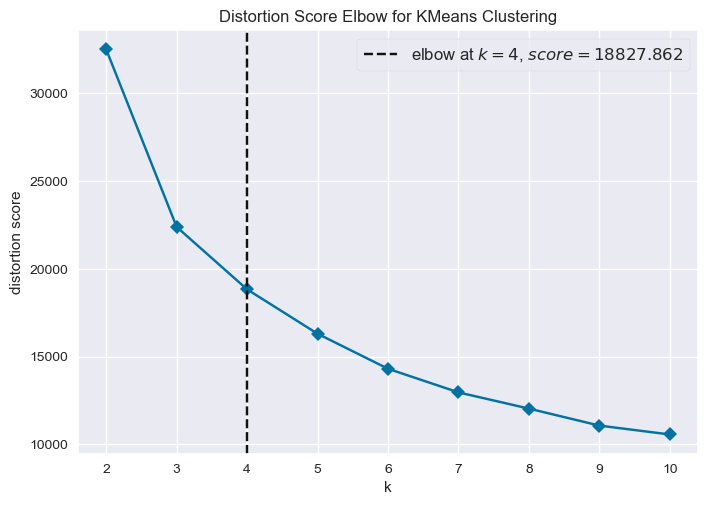

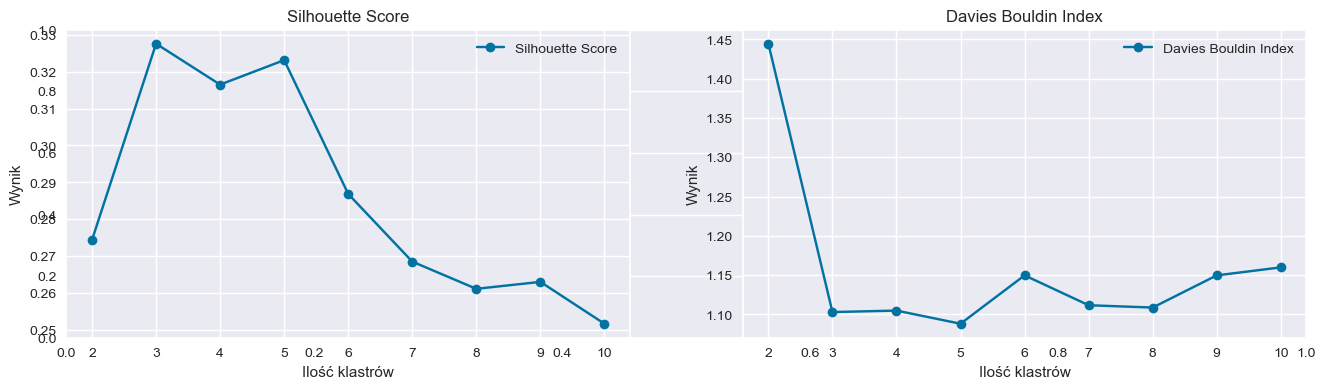

K Clusters  Davies Bouldin  Silhouette Score
0           3        1.103052          0.327534
1           5        1.088220          0.323091
2           4        1.104933          0.316469
3           6        1.149752          0.286875
4           2        1.444492          0.274431
5           7        1.111742          0.268556
6           9        1.149739          0.263075
7           8        1.108784          0.261193
8          10        1.159914          0.251748

In [ ]:
# Parametry algorytmu
K = range(2, 11)
kmeans_results = []

# Algorytm dla różnych parametrów
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=150, random_state=42)
    kmeans_clusters = kmeans.fit_predict(df)

    # Dodanie wyników do listy
    kmeans_results.append({
        'Cluster': kmeans_clusters,
        'K Clusters': k,
        'Davies Bouldin': davies_bouldin_score(df, kmeans_clusters),
        'Silhouette Score': silhouette_score(df, kmeans_clusters),
    })

kmeans_df = pd.DataFrame(kmeans_results)

# Wizualizacja wyników
visualizer = KElbowVisualizer(kmeans, k=K, timings=False)
visualizer.fit(df)
visualizer.show()

fig = plt.subplots(figsize=(16, 4))

plt.subplot(1,2,1)
plt.plot(kmeans_df['K Clusters'], kmeans_df['Silhouette Score'], marker='o', label='Silhouette Score')
plt.title('Silhouette Score')
plt.xlabel('Ilość klastrów')
plt.ylabel('Wynik')
plt.legend()

plt.subplot(1,2,2)
plt.plot(kmeans_df['K Clusters'], kmeans_df['Davies Bouldin'], marker='o', label='Davies Bouldin Index')
plt.title('Davies Bouldin Index')
plt.xlabel('Ilość klastrów')
plt.ylabel('Wynik')
plt.legend()

plt.show()

kmeans_results = sorted(kmeans_results, key=lambda x: x['Silhouette Score'], reverse=True)

kmeans_df = pd.DataFrame(kmeans_results)
kmeans_df.iloc[: , 1:]


Metoda łokciowa wykazała, że od parametru K = 4, wykres zaczyna się wypłaszczać dlatego optymalna ilość klastrów powinna znajdować się w tym obszarze. \
W przypadku indeksu Daviesa Bouldina najlepszy wynik uzyskano dla K = 5.
Poza grupowaniem dla parametru K = 2, ilość utworzonych grup nie wpływa znacząco na wynik tej metryki. \
Od wartości K = 5 maleje metryka Silhouette Score, a jej najlepsza wartość uzyskiwana jest dla K = 3.


### Statystyki dla trzech najlepszych skupień (o najwyższym wyniku Silhouette)

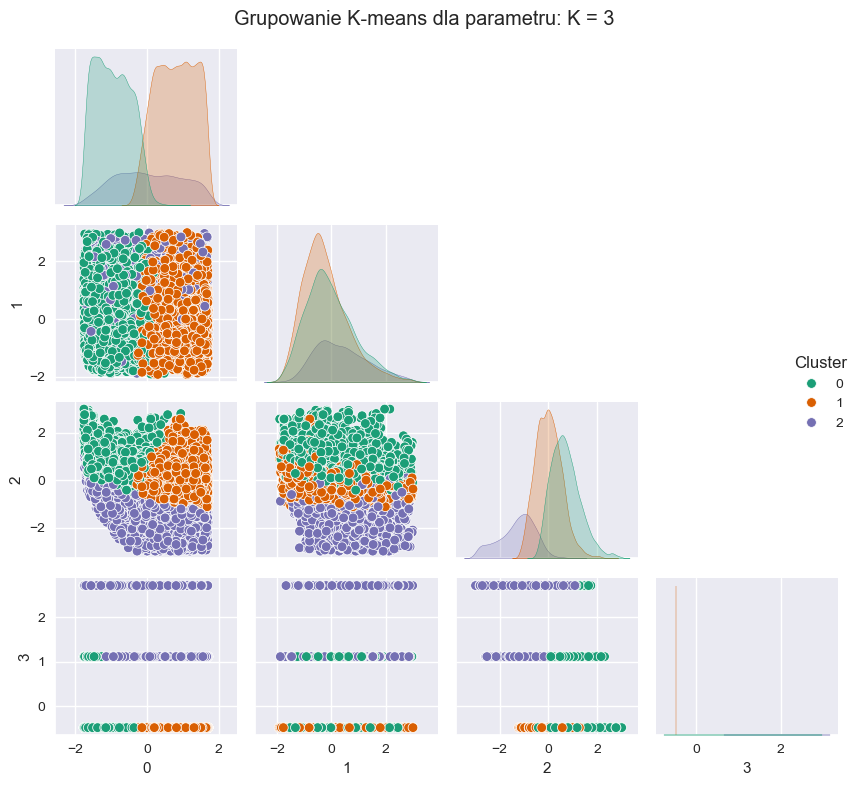

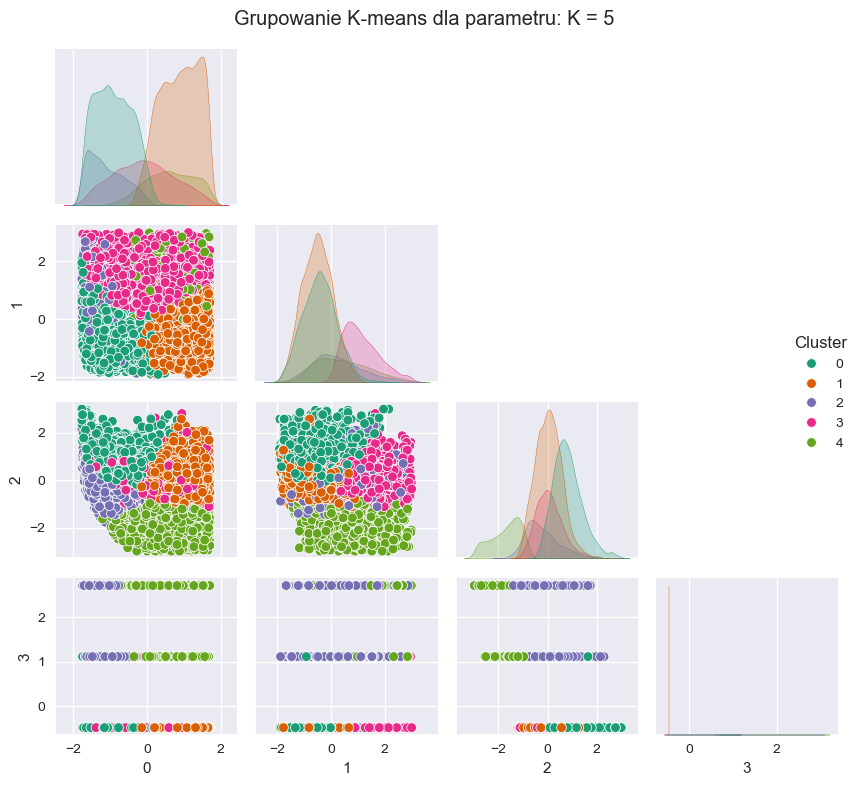

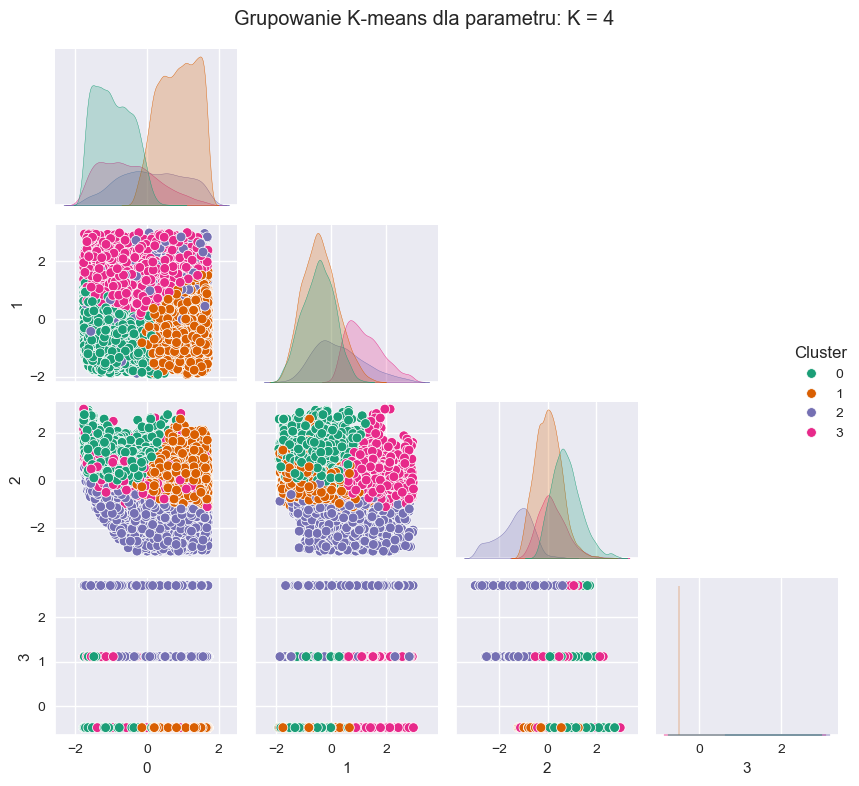

In [ ]:
chart_df = pd.DataFrame(df)

# Wizualizacja wykresów
for i in range(3):
    chart_df = chart_df.assign(Cluster=kmeans_df.loc[i, 'Cluster'])
    sns.pairplot(chart_df, hue='Cluster', palette='Dark2', corner=True, height=2)
    plt.suptitle(f'Grupowanie K-means dla parametru: K = {kmeans_df.loc[i, 'K Clusters']}')
    plt.tight_layout()
plt.show()

In [ ]:
kmeans_df = pd.DataFrame(kmeans_results)

# Wizualizacja wyników
for i in range(3):
    cluster_profile = original_df.groupby(kmeans_df.loc[i,'Cluster']).mean()
    cluster_profile['Count'] = original_df.groupby(kmeans_df.loc[i,'Cluster']).size()
    cluster_profile.columns = ['CA DistanceNominal (au)', 'V relative(km/s)','H(mag)', 'Rarity' ,'Count']

    print(f'Grupowanie K-means dla parametru: K = {kmeans_df.loc[i, 'K Clusters']}')
    display(cluster_profile)

Grupowanie K-means dla parametru: K = 3


CA DistanceNominal (au)  V relative(km/s)     H(mag)    Rarity  Count
0                 0.006029         10.153567  27.678466  0.103442   5201
1                 0.018952          9.167413  26.204711  0.000000   6030
2                 0.013539         12.257437  23.430435  1.276268   2208

Grupowanie K-means dla parametru: K = 5


CA DistanceNominal (au)  V relative(km/s)     H(mag)    Rarity  Count
0                 0.006423          8.195029  27.924375  0.004948   3840
1                 0.019540          7.812159  26.274263  0.000000   4816
2                 0.004980         11.481566  25.704819  1.158886   1328
3                 0.012457         16.063158  26.322584  0.010048   2090
4                 0.017672         12.630645  22.555311  1.301832   1365

Grupowanie K-means dla parametru: K = 4


CA DistanceNominal (au)  V relative(km/s)     H(mag)    Rarity  Count
0                 0.006147          7.955069  27.828647  0.094401   3983
1                 0.019417          8.299521  26.238859  0.000000   5244
2                 0.014143         11.851369  23.280175  1.296152   2053
3                 0.009354         16.495614  26.619870  0.147754   2159

Z wykresu oraz bazując na danych z tabel można zauważyć, że grupowanie nie utworzyło jednego skupienia, w których znajdowałaby się znaczna większość obserwacji. \
Wszystkie grupy posiadają dość zbalansowaną liczność obserwacji, bez grupy wyraźnie dominujących swoją licznością. \
Mała liczba klastrów zmniejsza różnice w średnich wartościach atrybutów. Wraz ze wzrostem liczby klastrów, rozkład danych między klastrami staje się bardziej szczegółowy. \
Przy większej liczbie klastrów dla tej metody możemy lepiej sklasyfikować dany obiekt o konkretnej charakterystyce do jednej z utworzonych grup.

#### B. Algorytm hierarchiczny: AHC
Do uzyskania najlepszych wyników grupowania przez aglomeracyjny algorytm hierarchiczny, wykorzystane zostaną wariacje 3 różnych parametrów tworzących skupienia.
Parametry wykorzystywane w algorytmie:
- N Cluster - ostateczna liczba klastrów. Wykorzystane wartości parametru: [3, 5, 7].
- Miara odległości - określenia podobieństwa między punktami i klastrami. Wykorzystanie wartości parametru: ['euclidean', 'manhattan'].
- Proces łączenia - określa sposób łączenia klastrów. Wykorzystanie wartości parametru: ['complete', 'average','single'].


In [ ]:
# Parametry algorytmu
n_clusters = [3,5,7]
distance_metrics = ['euclidean', 'manhattan']
linkage_methods = ['complete', 'average','single']
hierarchical_results = []

# Algorytm dla różnych parametrów
for n in n_clusters:
    for metric in distance_metrics:
        for linkage in linkage_methods:
            hierarchical = AgglomerativeClustering(n_clusters=n, metric=metric ,linkage=linkage)
            hierarchical_clusters = hierarchical.fit_predict(df)

            # Dodanie wyników do listy
            hierarchical_results.append({
                'Cluster': hierarchical_clusters,
                'N Clusters': n,
                'Metric': metric,
                'Linkage': linkage,
                'Davies Bouldin': davies_bouldin_score(df, hierarchical_clusters),
                'Silhouette Score': silhouette_score(df, hierarchical_clusters),
            })

hierarchical_results = sorted(hierarchical_results, key=lambda x: x['Silhouette Score'], reverse=True)
hierarchical_df = pd.DataFrame(hierarchical_results)

# Wyświetlenie tablicy danych
hierarchical_df.iloc[: , 1:]

N Clusters     Metric   Linkage  Davies Bouldin  Silhouette Score
0            3  manhattan   average        0.602637          0.383056
1            3  euclidean   average        1.004367          0.339765
2            3  manhattan  complete        1.215997          0.332564
3            3  euclidean  complete        1.237807          0.329941
4            3  euclidean    single        1.563388          0.324097
5            3  manhattan    single        1.563388          0.324097
6            5  manhattan    single        1.182125          0.295461
7            5  manhattan  complete        1.394190          0.294788
8            5  euclidean    single        1.114879          0.294304
9            5  manhattan   average        0.997384          0.284609
10           7  manhattan   average        1.076476          0.261482
11           5  euclidean  complete        1.250169          0.258256
12           7  euclidean   average        1.025785          0.256146
13           5  euclidean   average        0.958906          0.252374
14           7  euclidean  complete        1.299780          0.231473
15           7  manhattan  complete        1.321318          0.219808
16           7  euclidean    single        0.974717          0.216308
17           7  manhattan    single        0.974717          0.216308

Najwyższe wyniki Silhouette uzyskano dla małej ilości klastrów. Im większa wartość parametru N Clusters, tym gorszy wynik Silhouette. \
Ilość klastrów ma również największy wpływ na ostateczny wynik grupowania. Duża ilosc klastrów zmniejsza wynik Silhouette. \
Parametry miary odległości oraz procesu łączenia nie miały tak dużego wpływu na wynik Silhouette.


### Statystyki dla trzech najlepszych skupień (o najwyższym wyniku Silhouette)

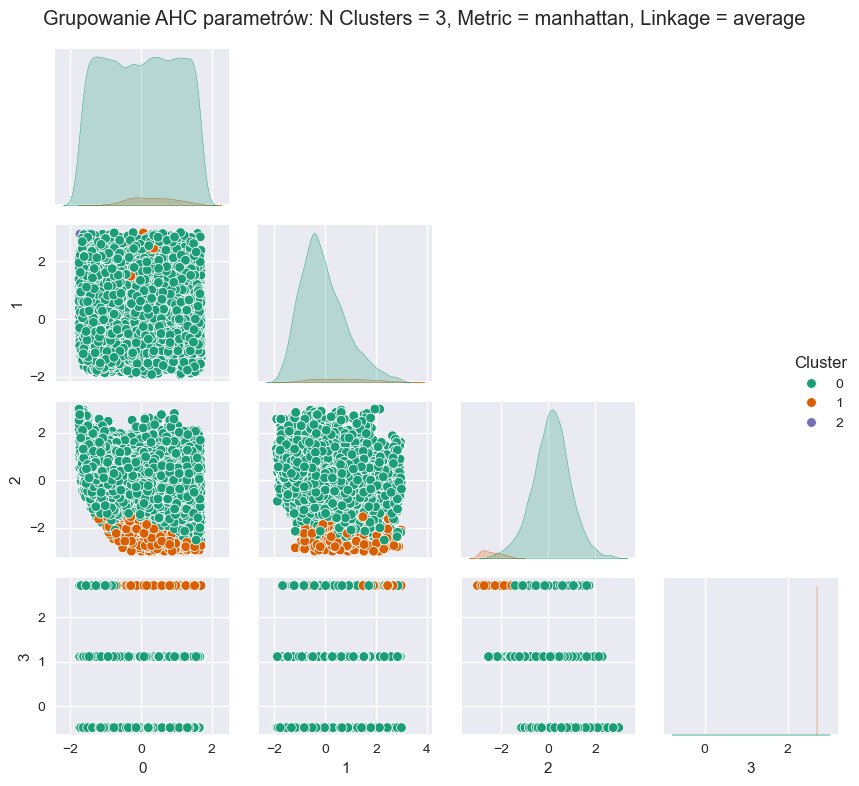

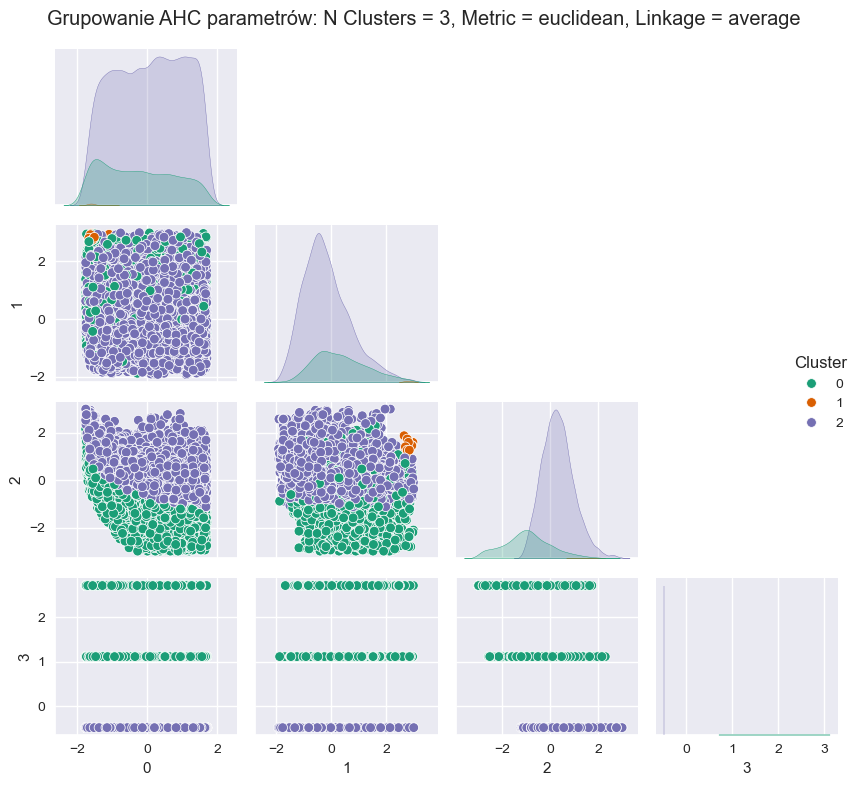

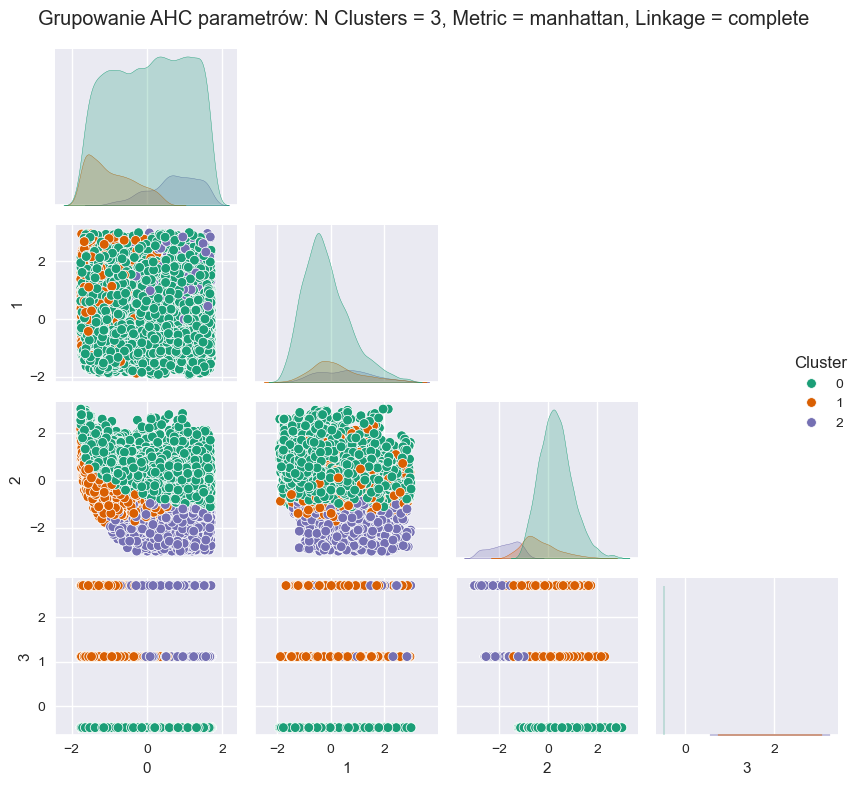

In [ ]:
chart_df = pd.DataFrame(df)

# Wizualizacja wykresów
for i in range(3):
    chart_df = chart_df.assign(Cluster=hierarchical_df.loc[i, 'Cluster'])
    sns.pairplot(chart_df, hue='Cluster', palette='Dark2', corner=True, height=2)
    plt.suptitle(f'Grupowanie AHC parametrów: N Clusters = {hierarchical_df.loc[i, 'N Clusters']},'
    f' Metric = {hierarchical_df.loc[i, 'Metric']}, Linkage = {hierarchical_df.loc[i, 'Linkage']}')
    plt.tight_layout()
plt.show()


In [ ]:
hierarchical_df = pd.DataFrame(hierarchical_results)

for i in range(3):
    cluster_profile = original_df.groupby(hierarchical_df.iloc[i]['Cluster']).mean()
    cluster_profile['Count'] = original_df.groupby(hierarchical_df.iloc[i]['Cluster']).size()
    cluster_profile.columns = ['CA DistanceNominal (au)', 'V relative(km/s)','H(mag)','Rarity', 'Count']

    print(f'Grupowanie AHC parametrów: N Clusters = {hierarchical_df.loc[i, 'N Clusters']},'
    f' Metric = {hierarchical_df.loc[i, 'Metric']}, Linkage = {hierarchical_df.loc[i, 'Linkage']}')
    display(cluster_profile)

Grupowanie AHC parametrów: N Clusters = 3, Metric = manhattan, Linkage = average


CA DistanceNominal (au)  V relative(km/s)     H(mag)    Rarity  Count
0                 0.012990          9.948479  26.473527  0.198069  13053
1                 0.015511         13.687714  21.082597  2.000000    385
2                 0.000230         25.350000  29.300000  1.000000      1

Grupowanie AHC parametrów: N Clusters = 3, Metric = euclidean, Linkage = average


CA DistanceNominal (au)  V relative(km/s)     H(mag)    Rarity  Count
0                 0.011311         12.118273  24.153348  1.227955   2733
1                 0.001523         24.557500  29.350000  0.000000     12
2                 0.013522          9.513624  26.869510  0.000000  10694

Grupowanie AHC parametrów: N Clusters = 3, Metric = manhattan, Linkage = complete


CA DistanceNominal (au)  V relative(km/s)     H(mag)    Rarity  Count
0                 0.013509          9.530486  26.872291  0.000000  10706
1                 0.006098         11.414350  25.476433  1.143312   1570
2                 0.018348         13.068538  22.367240  1.342218   1163

Każde grupowań o najwyższym wyniku Silhouette utworzyło jedno skupienie zawierające znaczną większą obserwacji ze zbioru danych. \
Parametry AHC (metryka i metoda łączenia) w większym stopniu wpłynęły na wielkość i rozmieszczenie powstałych skupień niż parametr N Clusters. \
Grupy o małej ilości obserwacji posiadają bardziej zróżnicowane wartości atrybutów co można zauważyć zarówno na wykresie, jak i w tabeli.\
Algorytm wykorzystujący parametr miary odległości 'manhattan' oraz metody łączenia 'average' utworzył bardzo szczegółowe grupy o małej ilości obserwacji. \
Dla algorytmu z parametrem metody łączenie 'complete' oprócz jednego dużego skupienia algorytm wygenerował też dwa mniejsze grupy o podobnej wielkości.

#### C. Algorytm gęstościowy: DBSCAN
Algorytm gęstościowy wykorzystywać będzie 3 parametry, w celu wybrania najlepszych parametrów do utworzenia skupień:
- Metryka odległości - określa sposób mierzenia podobieństwa lub różnicy między punktami. Wykorzystane wartości parametru: ['euclidean', 'manhattan', 'cosine']
- Promień sąsiedztwa - maksymalna odległość, w której punkty są uznawane za sąsiadujące. Wykorzystane wartości parametru: [0.25, 0.5, 1.0]
- Ilość minimalnych próbek w sąsiedztwie - minimalna liczba punktów, które muszą znajdować się w promieniu sąsiedztwa, aby można było utworzyć skupienie: [5, 10, 15]

In [ ]:
# Parametry algorytmu
distance_metrics = ['euclidean', 'manhattan', 'cosine']
eps_values = [0.25, 0.5, 1.0]
min_samples_values = [5, 10, 15]
dbscan_results = []


for metric in distance_metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            dbscan_clusters = dbscan.fit_predict(df)
            n_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
            if n_clusters > 1:
                dbscan_score = davies_bouldin_score(df, dbscan_clusters),
                dbscan_score = dbscan_score[0]
                sil_score = silhouette_score(df, dbscan_clusters)
            else:
                dbscan_score = -1
                sil_score = -1

            dbscan_results.append({
                'Cluster': dbscan_clusters,
                'Metric': metric,
                'Eps': eps,
                'Min samples': min_samples,
                'N Clusters': n_clusters,
                'Davies Bouldin': dbscan_score,
                'Silhouette Score': sil_score,

            })
# Wizualizacja wyników
dbscan_results = sorted(dbscan_results, key=lambda x: x['Silhouette Score'], reverse=True)
dbscan_df = pd.DataFrame(dbscan_results)

dbscan_df.iloc[:, 1:]

Metric   Eps  Min samples  N Clusters  Davies Bouldin  Silhouette Score
0   euclidean  1.00            5           3        1.563388          0.324097
1   euclidean  1.00           10           3        1.563388          0.324097
2   manhattan  1.00           15           3        1.833751          0.322420
3   manhattan  1.00           10           3        1.904848          0.322023
4   manhattan  1.00            5           3        1.886191          0.321609
5   euclidean  0.50           10           3        1.976082          0.320911
6   euclidean  0.50           15           3        2.198571          0.318638
7   euclidean  0.50            5           4        1.812899          0.311713
8   euclidean  1.00           15           3        1.288460          0.294630
9   manhattan  0.50           10           7        2.072210          0.246732
10  manhattan  0.50           15           9        1.886652          0.240750
11  manhattan  0.50            5           5        1.990147          0.172246
12  euclidean  0.25           10          10        2.134458          0.115411
13  euclidean  0.25           15           7        2.193825          0.043203
14  euclidean  0.25            5          40        1.544453         -0.132471
15  manhattan  0.25            5          86        1.322414         -0.451765
16  manhattan  0.25           10          35        1.707829         -0.461907
17  manhattan  0.25           15          23        1.548540         -0.507542
18     cosine  0.25            5           1       -1.000000         -1.000000
19     cosine  0.25           10           1       -1.000000         -1.000000
20     cosine  0.25           15           1       -1.000000         -1.000000
21     cosine  0.50            5           1       -1.000000         -1.000000
22     cosine  0.50           10           1       -1.000000         -1.000000
23     cosine  0.50           15           1       -1.000000         -1.000000
24     cosine  1.00            5           1       -1.000000         -1.000000
25     cosine  1.00           10           1       -1.000000         -1.000000
26     cosine  1.00           15           1       -1.000000         -1.000000

 Najwyższy wynik Silhouette uzyskiwały algorytmy, dla których parametr Eps = 1.0. Zmniejszenie wartości Eps znacząco wpływa na ilość tworzonych skupień. \
 Parametr Min sample nie miał większego wpływu na wynik Silhouette oraz liczbę generowanych klastrów w przypadku wysokich wartości Eps. Większa liczba klastrów znacząco zmniejsza wynik Silhouette. \
 Dla metryki Cosinusowej nie wygenerowano żadnych skupień, dlatego metryki Daviesa Bouldina i Silhouette wynoszą -1.


### Statystyki dla trzech najlepszych skupień (o najwyższym wyniku Silhouette)

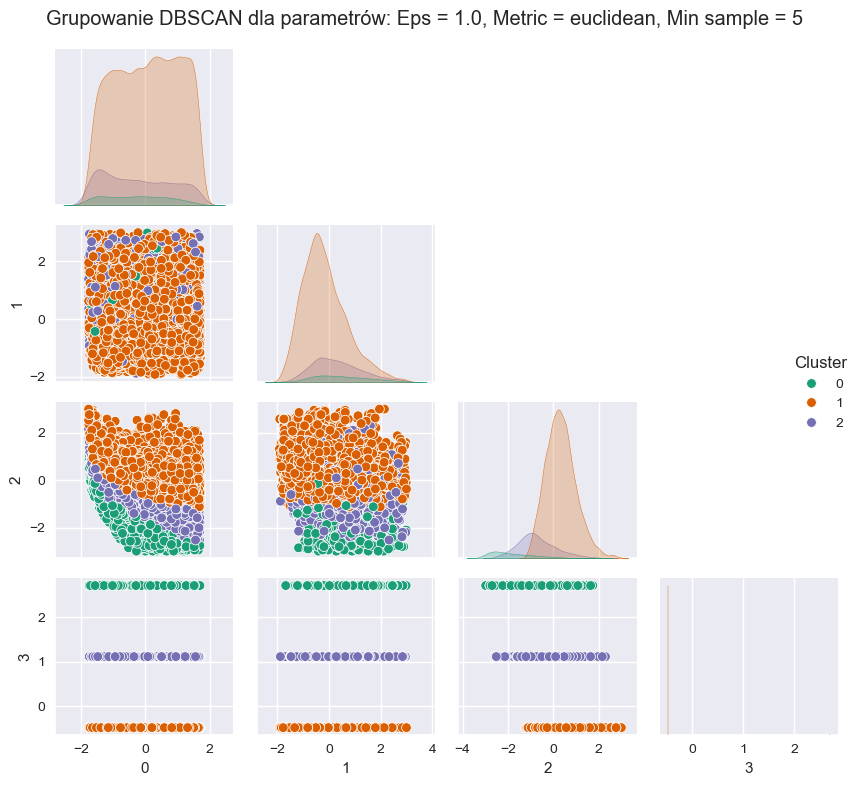

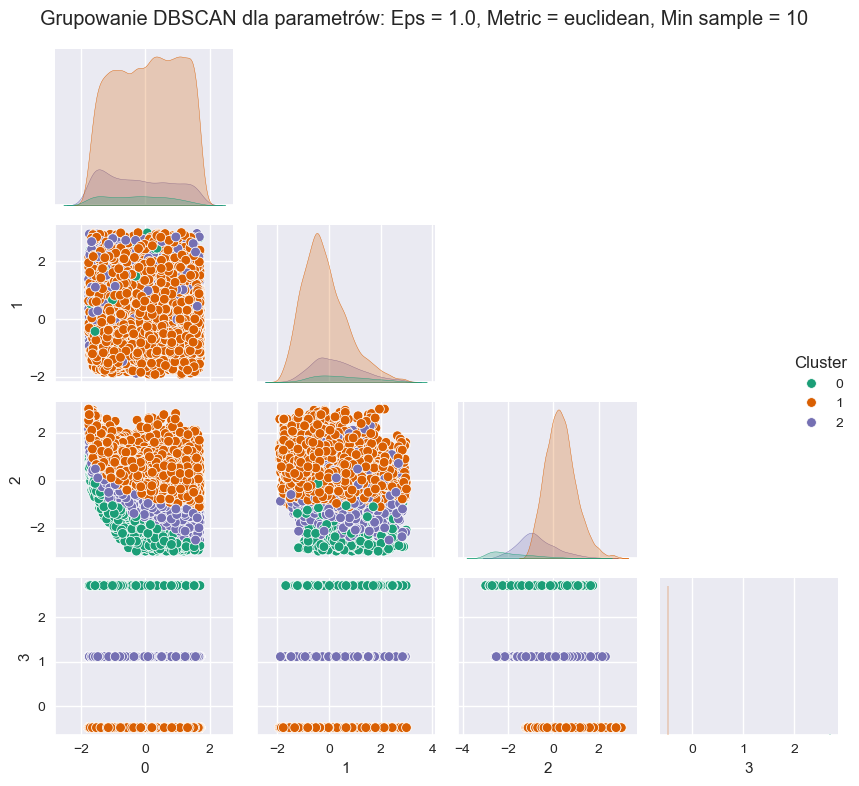

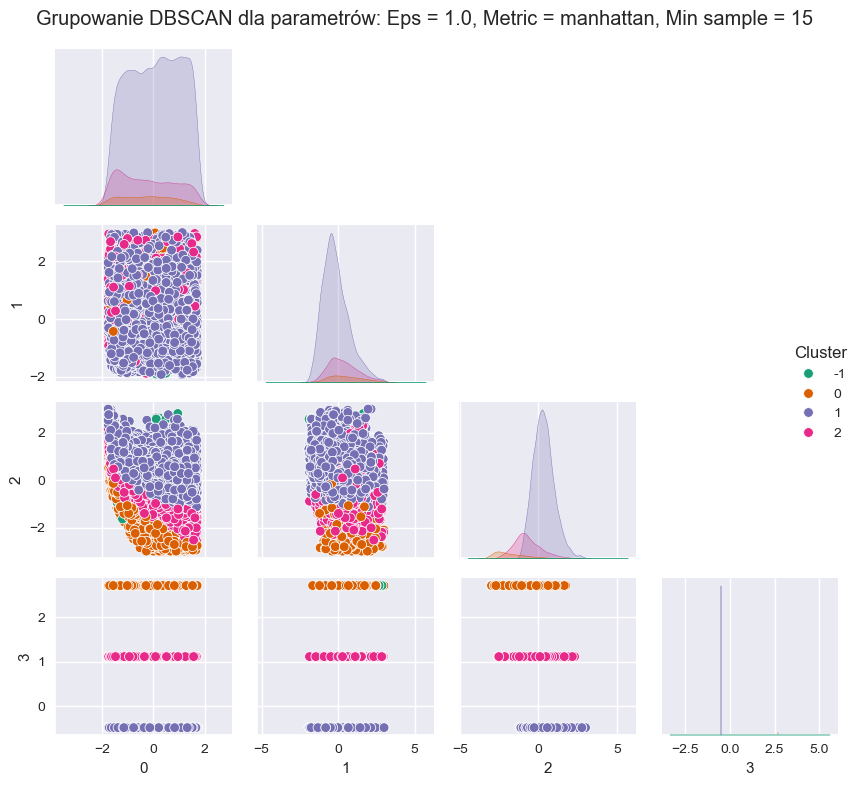

In [ ]:
dbscan_df = dbscan_df[dbscan_df['Silhouette Score'] > 0]
chart_df = pd.DataFrame(df)

# Wizualizacja wykresów
for i in range(3):
    chart_df = chart_df.assign(Cluster=dbscan_df.loc[i, 'Cluster'])
    sns.pairplot(chart_df, hue='Cluster', palette='Dark2', corner=True, height=2)
    plt.suptitle(f'Grupowanie DBSCAN dla parametrów: Eps = {dbscan_df.loc[i, 'Eps']},'
    f' Metric = {dbscan_df.loc[i, 'Metric']}, Min sample = {dbscan_df.loc[i, 'Min samples']}')
    plt.tight_layout()
plt.show()


In [ ]:
dbscan_df = pd.DataFrame(dbscan_results)

# Wizualizacja wyników
for i in range(3):
    cluster_profile = original_df.groupby(dbscan_df.loc[i, 'Cluster']).mean()
    cluster_profile['Count'] = original_df.groupby(dbscan_df.loc[i, 'Cluster']).size()
    cluster_profile.columns = ['CA DistanceNominal (au)', 'V relative(km/s)','H(mag)','Rarity', 'Count']

    print(f'Grupowanie DBSCAN dla parametrów: Eps = {dbscan_df.loc[i, 'Eps']},'
    f' Metric = {dbscan_df.loc[i, 'Metric']}, Min sample = {dbscan_df.loc[i, 'Min samples']}')
    display(cluster_profile)

Grupowanie DBSCAN dla parametrów: Eps = 1.0, Metric = euclidean, Min sample = 5


CA DistanceNominal (au)  V relative(km/s)     H(mag)  Rarity  Count
0                 0.011001         12.765377  22.500161     2.0    623
1                 0.013509          9.530486  26.872291     0.0  10706
2                 0.011402         11.927209  24.641469     1.0   2110

Grupowanie DBSCAN dla parametrów: Eps = 1.0, Metric = euclidean, Min sample = 10


CA DistanceNominal (au)  V relative(km/s)     H(mag)  Rarity  Count
0                 0.011001         12.765377  22.500161     2.0    623
1                 0.013509          9.530486  26.872291     0.0  10706
2                 0.011402         11.927209  24.641469     1.0   2110

Grupowanie DBSCAN dla parametrów: Eps = 1.0, Metric = manhattan, Min sample = 15


CA DistanceNominal (au)  V relative(km/s)     H(mag)    Rarity  Count
-1                 0.007885         18.493846  27.515385  1.230769     13
 0                 0.011111         12.635024  22.466829  2.000000    615
 1                 0.013507          9.529507  26.870156  0.000000  10701
 2                 0.011402         11.927209  24.641469  1.000000   2110

Tak jak w przypadku algorytmu hierarchicznego, algorytm wygenerował jedno dominujące skupienie we wszystkich trzech analizowanych działań algorytmu. \
Na wykresie oraz w tabeli zaobserwować można, że jeden z klastrów posiada znaczną większość obserwacji i znacząco dominuje swoją licznością nad pozostałymi skupieniami. \
Dla pierwszych dwóch algorytmów o najwyższym wyniku Silouette, algorytm wygenerował dokładnie takie same skupienia niezależnie od wartości parametru Min sample. \
Dla trzeciego algorytmu o najwyższym wyniku Silouette można zauważyć, że algorytm oznaczył niektóre obserwacje jako szum i zgrupował je w klaster -1.

## 4. Porównanie algorytmów

### Miary oceny jakości grupowania dla algorytmów o najlepszym wyniku Silhouette
Do zmierzenia jakości klasyfikacji wykorzystane zostaną wykorzystane następujące miary:

- NMI (Normalized Mutual Information) - mierzy ilość informacji wspólnej między dwoma rozkładami. Wartości NMI mieszczą się w przedziale od 0 (brak wspólnej informacji) do 1 (pełna zgodność).
- FMI (Fowlkes-Mallows Index) - ocenia jakość klasteryzacji, porównując pary punktów, które zostały przypisane do tych samych lub różnych klastrów w dwóch algorytmach. \
Wynik FMI mieści się w przedziale od 0 (brak zgodności) do 1 (pełna zgodność).
- Jaccard (Jaccard Similarity Coefficient) - mierzy podobieństwo dwóch zbiorów na podstawie liczby punktów wspólnych oraz łącznej liczby punktów, które zostały przypisane do klastrów w obu \
algorytmach. Wynik Jaccarda mieści się w przedziale od 0 (brak podobieństwa) do 1 (pełne podobieństwo).

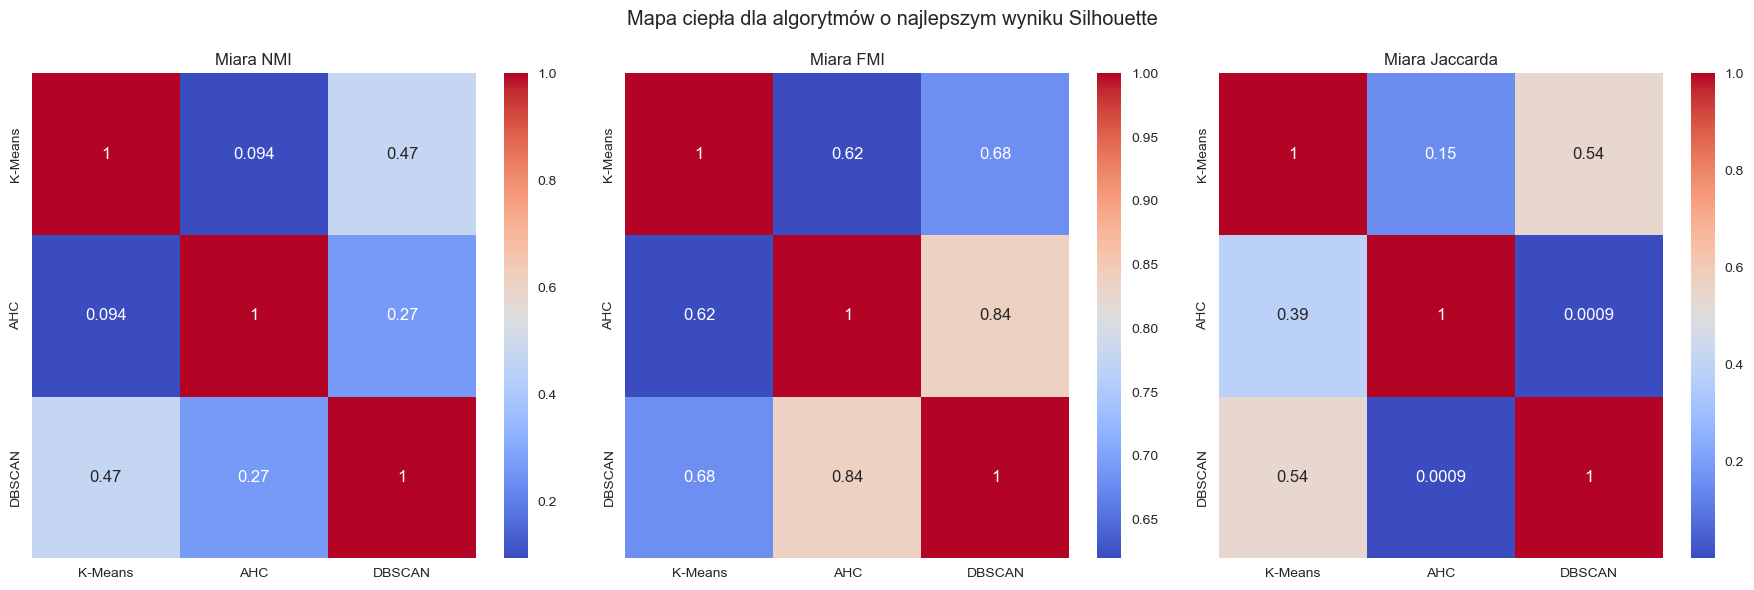

In [ ]:
labels_list = [kmeans_results, hierarchical_results, dbscan_results]
methods = ["K-Means", "AHC", "DBSCAN"]

nmi_matrix = np.zeros((len(labels_list), len(labels_list)))
fmi_matrix = np.zeros((len(labels_list), len(labels_list)))
jaccard_matrix = np.zeros((len(labels_list), len(labels_list)))

for i in range(len(labels_list)):
    for j in range(len(labels_list)):
        if methods[i] == 'DBSCAN' and methods[j] != 'DBSCAN':
            labels1 = labels_list[i][0]['Cluster']
            labels1 = labels1[labels_list[i][0]['Cluster'] != -1]
            labels2 = labels_list[j][0]['Cluster']
            labels2 = labels2[labels_list[i][0]['Cluster'] != -1]
        elif methods[j] == 'DBSCAN' and methods[i] != 'DBSCAN':
            labels1 = labels_list[j][0]['Cluster']
            labels1 = labels1[labels_list[j][0]['Cluster'] != -1]
            labels2 = labels_list[i][0]['Cluster']
            labels2 = labels2[labels_list[j][0]['Cluster'] != -1]
        else:
            labels1 = labels_list[i][0]['Cluster']
            labels2 = labels_list[j][0]['Cluster']

        nmi_matrix[i, j] = normalized_mutual_info_score(labels1, labels2)
        fmi_matrix[i, j] = fowlkes_mallows_score(labels1, labels2)
        jaccard_matrix[i, j] = jaccard_score(labels1, labels2, average='weighted')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

sns.heatmap(nmi_matrix, annot=True, cmap="coolwarm", xticklabels=methods, yticklabels=methods, ax=axes[0])
axes[0].set_title("Miara NMI")

sns.heatmap(fmi_matrix, annot=True, cmap="coolwarm", xticklabels=methods, yticklabels=methods, ax=axes[1])
axes[1].set_title("Miara FMI")

sns.heatmap(jaccard_matrix, annot=True, cmap="coolwarm", xticklabels=methods, yticklabels=methods, ax=axes[2])
axes[2].set_title("Miara Jaccarda")

plt.suptitle('Mapa ciepła dla algorytmów o najlepszym wyniku Silhouette')
plt.tight_layout()
plt.show()

### Dla miary NMI:
- K-Means - AHC: 0.094 - niska wartość sugeruje, że te dwa algorytmy generują różne rozkłady klastrów, co może oznaczać, że K-Means i AHC wykonują klasteryzację w zupełnie odmienny sposób.
- K-Means - DBSCAN: 0.47 - umiarkowaną zgodność między wynikami klasteryzacji. Oba algorytmy trafnie identyfikują niektóre podobne struktury w danych. (Najwyższa dla tej miary).
- AHC - DBSCAN: 0.27 - niski poziom podobieństwa między wynikami. Oba algorytmy generują dość różne podziały danych.

### Dla miary FMI:
- K-Means - AHC: 0.62 - umiarkowana zgodność między klastrami. Skupienia są na tyle podobne, że wciąż jest spora liczba poprawnie przypisań punktów w obu metodach.
- K-Means - DBSCAN: 0.68 - dość duża zgodność między K-Means, a DBSCANem.
- AHC - DBSCAN: 0.84 - bardzo wysoka zgodność między klastrami.  Wyniki algorytmów są bardzo podobne, co może sugerować, że dane posiadają wyraźne struktury, które są rozpoznawane przez oba algorytmy. (Najwyższa dla tej miary)

### Dla miary Jaccarda:
- K-Means - AHC: 0.39 - niskie podobieństwo między wypisanymi punktami.
- K-Means - DBSCAN: 0.54 - umiarkowaną zgodność w przypisaniu punktów do klastrów. (Najwyższa dla tej miary)
- AHC - DBSCAN: 0.0009 - minimalne podobieństwo bliskie zeru.

### Wykres trzech najlepszych grupowań każdego z algorytmów dla pary atrybutów: V relative(km/s) i H(mag)

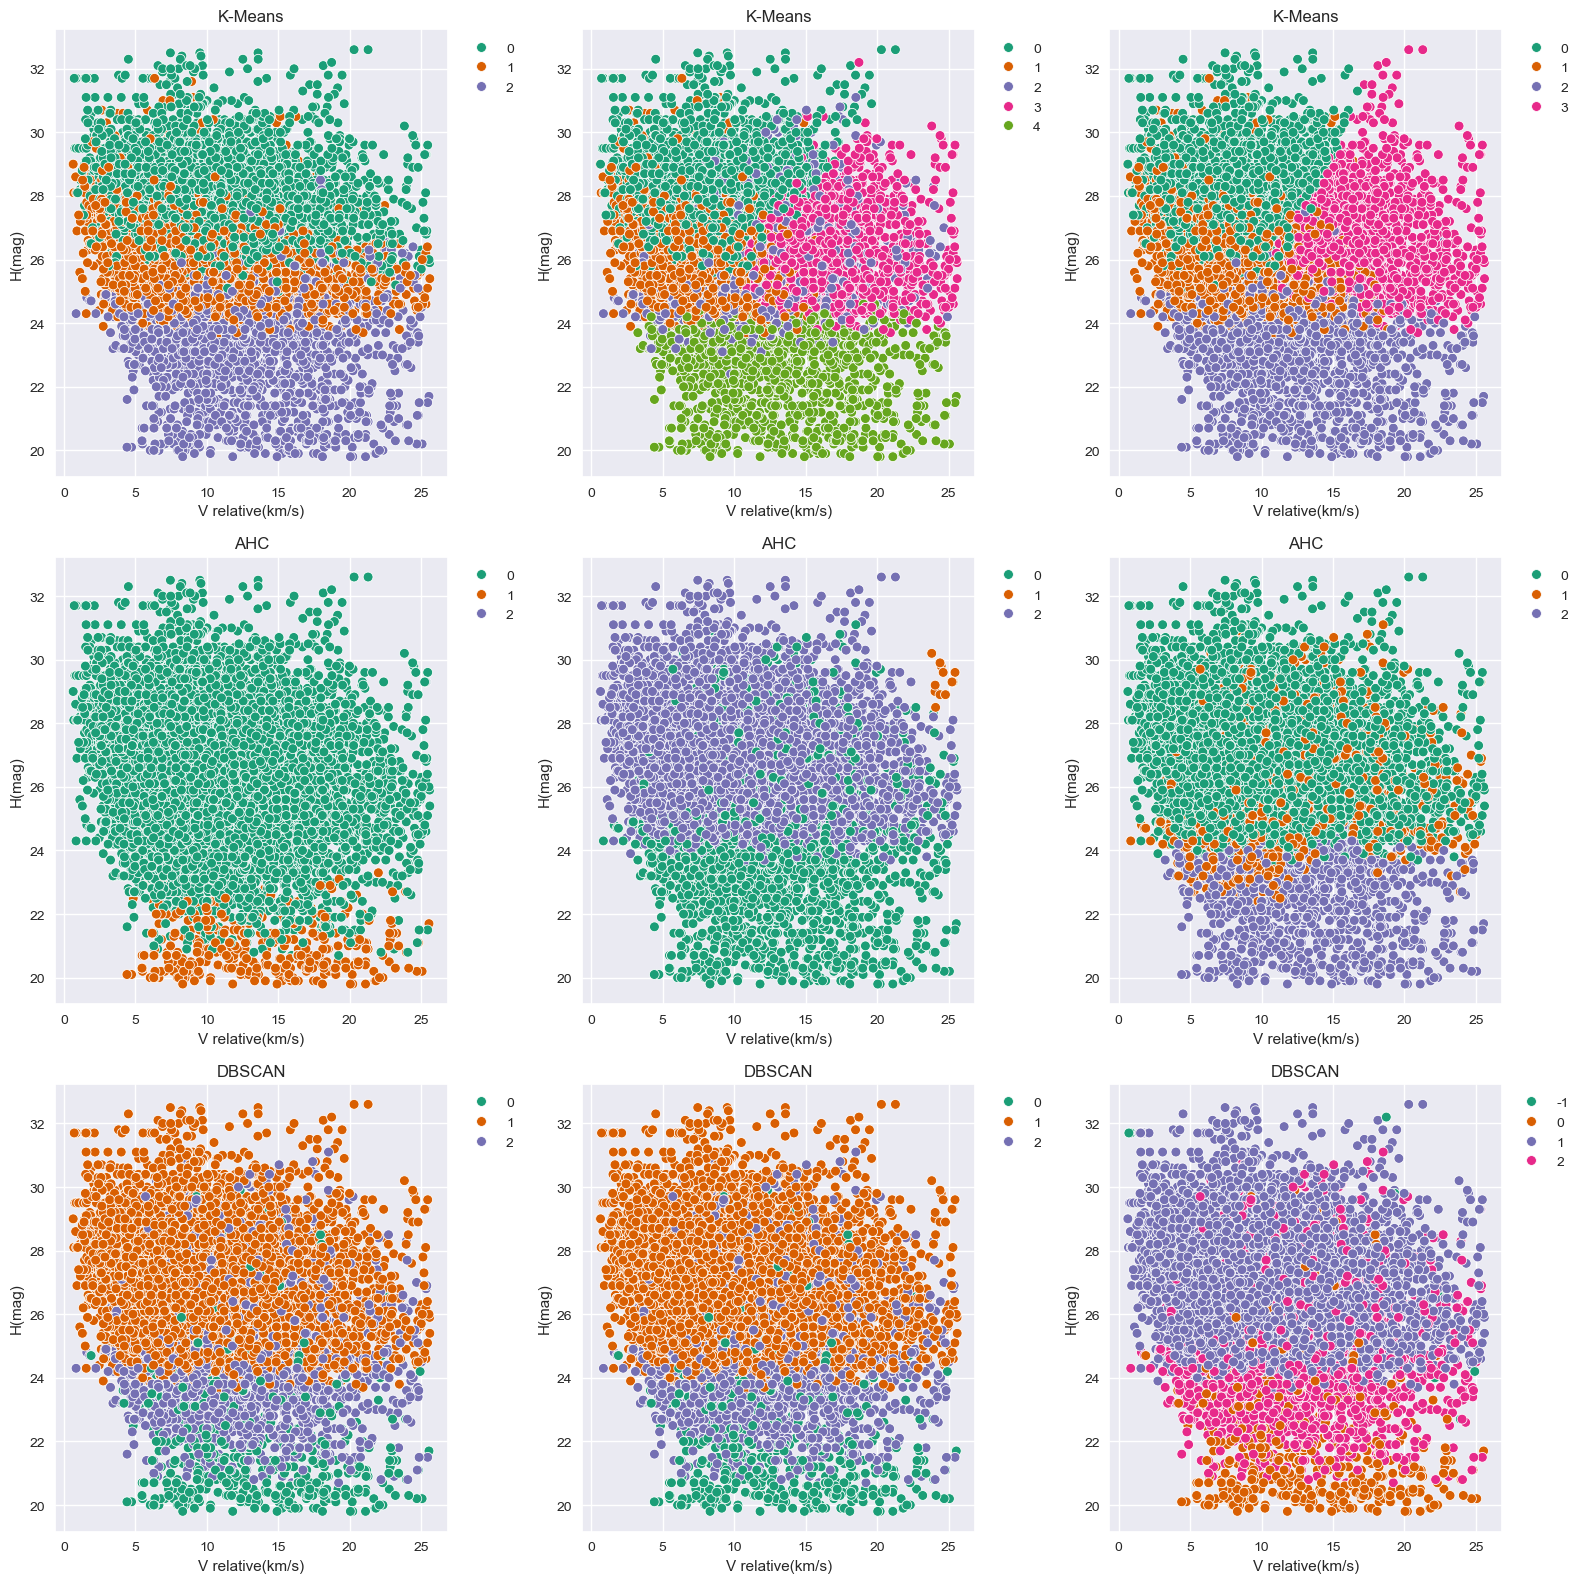

In [ ]:
plt.figure(figsize=(16,16))
cnt = 0
for i in range(len(labels_list)):
    for j in range(3):
        cnt = cnt + 1
        plt.subplot(3, 3, cnt)
        sns.scatterplot(x=original_df['V relative(km/s)'], y=original_df['H(mag)'], hue=labels_list[i][j]['Cluster'], s=50, palette='Dark2')
        plt.legend(bbox_to_anchor=(1.2, 1.0))
        plt.title(methods[i])
        plt.tight_layout()
plt.show()

Wszystkie algorytmy uzyskały bardzo podobny wynik Silouette w przypadku najlepszy parametrów dobranych dla każdego z algorytmów. \
Algorytm K-means podzielił zbiór danych w najbardziej równy sposób, w porównaniu do reszty algorytmów. Wybór odpowiedniej wartości parametru K miał też wpływ na jakość tworzonych skupień. \
Algorytmy AHC oraz DBSCAN poza jednym dużym skupieniem, utworzyły również kilka mniejszych, które mogą lepiej charakteryzować obiekty o tych właśnie cechach. \
Zmiana parametrów w algorytmie DBSCAN w bardzo niewielkim stopniu wpłynęła na grupowanie, co może świadczyć o tym, że dane posiadają wyraźną, \
strukturę, która była dobrze rozpoznawana przez algorytm, bez względu na jego parametry. \
Algorytm hierarchiczny AHC uzyskał najwyższy wynik Silouette spośród wszystkich algorytmów wynoszący 0.383056. W przypadku tego algorytmu dobór parametrów miał duży wpływ \
na charakterystykę mniejszych skupień utworzonych przez tę metodę.

Na podstawie przeprowadzonej analizy można zaobserwować, że każdy z algorytmów w inny sposób grupuje dane, co w rezultacie skutkuje różnym rozkładem i ilością skupień. \
Pomimo różnic w działaniu algorytmu między różnymi podejściami da się zaobserwować podobne struktury grupowania obiektów. W zależności od potrzeb algorytmy mogą grupować obserwacje w bardziej \
szczegółowy sposób wprowadzając większą rozróżnialność poszczególnych obiektów lub wręcz przeciwnie uogólniając tworzone skupienia. W przypadku tego zbioru udało się utworzyć skupienia zarówno \
dla obiektów o bardziej szczegółowej charakterystyce, jak również skupienia bardziej różnorodne. Zmiana parametrów w każdym z algorytmów miała wpływ na ostateczną ilość grup oraz przypisanie \
obserwacji do poszczególnych skupień.
